https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [126]:
import re
import pandas as pd
from time import time
from collections import defaultdict

import spacy

In [127]:
from gensim.models.phrases import Phrases, Phraser

In [128]:
import multiprocessing

from gensim.models import Word2Vec

In [129]:
import logging
# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [130]:
df = pd.read_csv('../data/jeopardy_regular_episodes.csv')
q_and_a = df[['Question', 'Answer', 'Question and Answer']]
q_and_a.head()

,Question,Answer,Question and Answer
0,the Jordan,River mentioned most often in the Bible,the Jordan River mentioned most often in the B...
1,loch,Scottish word for lake,loch Scottish word for lake
2,the Missouri,American river only 33 miles shorter than the ...,the Missouri American river only 33 miles shor...
3,the Caspian Sea,Worlds largest lake nearly 5 times as big as S...,the Caspian Sea Worlds largest lake nearly 5 t...
4,the radio,Marconis wonderful wireless,the radio Marconis wonderful wireless


In [131]:
q_and_a.isnull().sum()

Question               0
Answer                 0
Question and Answer    0
dtype: int64

In [132]:
# Remove ner and parser for speed (entity recognition)
nlp = spacy.load('en', disable=['ner', 'parser'])

In [133]:
stopwords_txt = open("../src/stopwords.txt")
my_stopwords = set(stopwords_txt.read().split(","))
my_stopwords

{' 000',
 ' 1',
 ' 10',
 ' 100',
 ' 2',
 ' 20',
 ' 200',
 ' 3',
 ' 30',
 ' 4',
 ' 40',
 ' 5',
 ' 50',
 ' 6',
 ' 60',
 ' 7',
 ' 70',
 ' 8',
 ' 80',
 ' 9',
 ' 90',
 ' also',
 ' around',
 ' back',
 ' bad',
 ' be',
 ' become',
 ' big',
 ' black',
 ' bottom',
 ' boy',
 ' call',
 ' can',
 ' city',
 ' contain',
 ' could',
 ' country',
 ' day',
 ' fail',
 ' fake',
 ' final',
 ' first',
 ' five',
 ' four',
 ' front',
 ' get',
 ' girl',
 ' go',
 ' good',
 ' he',
 ' i',
 ' ii',
 ' iii',
 ' include',
 ' island',
 ' know',
 ' land',
 ' large',
 ' last',
 ' left',
 ' life',
 ' long',
 ' loose',
 ' make',
 ' many',
 ' may',
 ' mean',
 ' middle',
 ' might',
 ' month',
 ' must',
 ' name',
 ' need',
 ' new',
 ' novel',
 ' often',
 ' one',
 ' original',
 ' pass',
 ' people',
 ' person',
 ' rare',
 ' real',
 ' right',
 ' river',
 ' s',
 ' say',
 ' second',
 ' she',
 ' short',
 ' show',
 ' side',
 ' small',
 ' sometime',
 ' state',
 ' take',
 ' tall',
 ' tell',
 ' term',
 ' they',
 ' thing',
 ' think',
 ' 

In [134]:
nlp.Defaults.stop_words |= my_stopwords

In [135]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [136]:
#Removes non-alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in q_and_a['Question and Answer'])


In [137]:
# Use spaCy .pipe() attribute to speed-up the cleaning process:

t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print ("Time to clean up everything: {} mins".format(round((time()-t)/60, 2)))

Time to clean up everything: 2.9 mins


In [46]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna()
df_clean.shape

(266827, 1)

In [47]:
df_clean.head()

,clean
0,river mention bible
1,scottish word lake
2,american river mile shorter mississippi
3,world large lake nearly time big superior
4,marconis wonderful wireless


Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html


In [138]:
sent = [row.split() for row in df_clean['clean']]
sent

[['river', 'mention', 'bible'],
 ['scottish', 'word', 'lake'],
 ['american', 'river', 'mile', 'shorter', 'mississippi'],
 ['world', 'large', 'lake', 'nearly', 'time', 'big', 'superior'],
 ['marconis', 'wonderful', 'wireless'],
 ['american', 'minister', 'create', 'oriental', 'transportation'],
 ['s',
  'hunting',
  'trip',
  'canada',
  'inspire',
  'birdseyes',
  'food',
  'preserve',
  'method'],
 ['fastener', 'get', 'brand', 'galosh'],
 ['rodent', 'get', 'america', 'stow', 'away', 'ship'],
 ['muscle', 'tendon', 'elephant', 'body'],
 ['husband', 'pop', 'ermine', 'coat', 'actually', 'buy', 'fur'],
 ['close', 'relative', 'pig', 'mean', 'river', 'horse'],
 ['species', 'hybrid', 'parent', 'reverse', 'd', 'hinny'],
 ['coq', 'coq', 'au', 'vin'],
 ['british', 'variety', 'call', 'banger', 'mexican', 'variety', 'chorizo'],
 ['jewish', 'crepe', 'fill', 'cheese'],
 ['french', 'toothsome', 'cut', 'beef', 'serve', 'twosome'],
 ['video', 'michael', 'jackson', 'play', 'werewolf', 'zombie'],
 ['satur

In [139]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 11:50:04: collecting all words and their counts
INFO - 11:50:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 11:50:05: PROGRESS: at sentence #10000, processed 68663 words and 68212 word types
INFO - 11:50:05: PROGRESS: at sentence #20000, processed 140813 words and 126797 word types
INFO - 11:50:05: PROGRESS: at sentence #30000, processed 213954 words and 180815 word types
INFO - 11:50:05: PROGRESS: at sentence #40000, processed 285358 words and 231412 word types
INFO - 11:50:05: PROGRESS: at sentence #50000, processed 359570 words and 282142 word types
INFO - 11:50:05: PROGRESS: at sentence #60000, processed 435403 words and 332858 word types
INFO - 11:50:05: PROGRESS: at sentence #70000, processed 509340 words and 381194 word types
INFO - 11:50:06: PROGRESS: at sentence #80000, processed 582082 words and 426580 word types
INFO - 11:50:06: PROGRESS: at sentence #90000, processed 655184 words and 471484 word types
INFO - 11:50:06: PROGRESS: at sentence #1

Transform the corpus based on the bigrams detected:

In [50]:
bigram = Phraser(phrases)

INFO - 14:53:29: source_vocab length 1224226
INFO - 14:53:38: Phraser built with 788 phrasegrams


In [51]:
sentences = bigram[sent]
sentences

In [52]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

100753

In [54]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


['s', 'city', 'name', 'call', 'play', 'say', 'man', 'state', 'know', 'type']

In [58]:
cores = multiprocessing.cpu_count()
cores #12 cores

12

### The parameters:

- `min_count` = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- `window` = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- `size` = int - Dimensionality of the feature vectors. - (50, 300)
- `sample` = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- `alpha` = float - The initial learning rate - (0.01, 0.05)
- `min_alpha` = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
= `negative` = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- `workers` = int - Use these many worker threads to train the model (=faster training with multicore machines)

## a) set of the parameters of the Word2Vec model 

In [59]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## b) build the vocabulary
from a seuences of sentences and initializes the model. Here we can see the effect of min_count and sample on te word corpus. These parameters have a big infludence over the model and if we can display both we can get a better idea of their influence 

In [60]:
t = time()

w2v_model.build_vocab(sentences, progress_per = 10000)

print("Time to build vocab: {} mind".format(round((time()-t)/60, 2)))

INFO - 14:58:42: collecting all words and their counts
INFO - 14:58:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:58:42: PROGRESS: at sentence #10000, processed 66527 words, keeping 15448 word types
INFO - 14:58:42: PROGRESS: at sentence #20000, processed 136346 words, keeping 23038 word types
INFO - 14:58:42: PROGRESS: at sentence #30000, processed 207025 words, keeping 28696 word types
INFO - 14:58:43: PROGRESS: at sentence #40000, processed 276033 words, keeping 33825 word types
INFO - 14:58:43: PROGRESS: at sentence #50000, processed 347677 words, keeping 38986 word types
INFO - 14:58:43: PROGRESS: at sentence #60000, processed 421034 words, keeping 43411 word types
INFO - 14:58:43: PROGRESS: at sentence #70000, processed 492587 words, keeping 47247 word types
INFO - 14:58:43: PROGRESS: at sentence #80000, processed 562813 words, keeping 50760 word types
INFO - 14:58:43: PROGRESS: at sentence #90000, processed 633491 words, keeping 54035 word types

Time to build vocab: 0.12 mind


## C) Training of the model:
**Parameters of the training:**

- `total_examples` = int - Count of sentences;
- `epochs` = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [61]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:01:42: training model with 11 workers on 10949 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:01:43: EPOCH 1 - PROGRESS: at 15.72% examples, 162473 words/s, in_qsize 0, out_qsize 0
INFO - 15:01:44: EPOCH 1 - PROGRESS: at 31.93% examples, 167691 words/s, in_qsize 0, out_qsize 0
INFO - 15:01:45: EPOCH 1 - PROGRESS: at 46.57% examples, 162755 words/s, in_qsize 0, out_qsize 0
INFO - 15:01:46: EPOCH 1 - PROGRESS: at 61.25% examples, 162067 words/s, in_qsize 0, out_qsize 0
INFO - 15:01:47: EPOCH 1 - PROGRESS: at 73.43% examples, 156563 words/s, in_qsize 0, out_qsize 0
INFO - 15:01:48: EPOCH 1 - PROGRESS: at 87.61% examples, 156521 words/s, in_qsize 0, out_qsize 0
INFO - 15:01:49: worker thread finished; awaiting finish of 10 more threads
INFO - 15:01:49: worker thread finished; awaiting finish of 9 more threads
INFO - 15:01:49: worker thread finished; awaiting finish of 8 more threads
INFO - 15:01:49: worker thread finished; awaiting finish

INFO - 15:02:21: EPOCH 6 - PROGRESS: at 59.72% examples, 154379 words/s, in_qsize 0, out_qsize 0
INFO - 15:02:22: EPOCH 6 - PROGRESS: at 73.94% examples, 155191 words/s, in_qsize 0, out_qsize 0
INFO - 15:02:23: EPOCH 6 - PROGRESS: at 89.09% examples, 156776 words/s, in_qsize 0, out_qsize 0
INFO - 15:02:23: worker thread finished; awaiting finish of 10 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 9 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 8 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 7 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 6 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 5 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 4 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 3 more threads
INFO - 15:02:23: worker thread finished; awaiting finish of 2 more threads
INFO - 15:02:23: worker thread fi

INFO - 15:02:59: worker thread finished; awaiting finish of 10 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 9 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 8 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 7 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 6 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 5 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 4 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 3 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 2 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 1 more threads
INFO - 15:02:59: worker thread finished; awaiting finish of 0 more threads
INFO - 15:02:59: EPOCH - 11 : training on 1944080 raw words (1100260 effective words) took 7.2s, 153560 effective words/s
INFO - 15:03:00: EPOCH 12 - PROGRESS: at 14.66% exam

INFO - 15:03:34: worker thread finished; awaiting finish of 7 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 6 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 5 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 4 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 3 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 2 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 1 more threads
INFO - 15:03:34: worker thread finished; awaiting finish of 0 more threads
INFO - 15:03:34: EPOCH - 16 : training on 1944080 raw words (1100338 effective words) took 6.7s, 165091 effective words/s
INFO - 15:03:35: EPOCH 17 - PROGRESS: at 16.78% examples, 171279 words/s, in_qsize 0, out_qsize 0
INFO - 15:03:37: EPOCH 17 - PROGRESS: at 31.93% examples, 158725 words/s, in_qsize 0, out_qsize 0
INFO - 15:03:38: EPOCH 17 - PROGRESS: at 48.12% examples, 162461 words/s, in_qsize

INFO - 15:04:07: worker thread finished; awaiting finish of 0 more threads
INFO - 15:04:07: EPOCH - 21 : training on 1944080 raw words (1101003 effective words) took 6.4s, 172242 effective words/s
INFO - 15:04:08: EPOCH 22 - PROGRESS: at 16.78% examples, 174573 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:09: EPOCH 22 - PROGRESS: at 30.36% examples, 159472 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:10: EPOCH 22 - PROGRESS: at 45.53% examples, 160261 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:11: EPOCH 22 - PROGRESS: at 60.22% examples, 160246 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:12: EPOCH 22 - PROGRESS: at 74.95% examples, 160947 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:13: EPOCH 22 - PROGRESS: at 89.58% examples, 161306 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:14: worker thread finished; awaiting finish of 10 more threads
INFO - 15:04:14: worker thread finished; awaiting finish of 9 more threads
INFO - 15:04:14: worker thread finished; awaiting finish of 8 mo

INFO - 15:04:46: EPOCH 27 - PROGRESS: at 60.22% examples, 158922 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:47: EPOCH 27 - PROGRESS: at 75.98% examples, 161899 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:48: EPOCH 27 - PROGRESS: at 92.04% examples, 164608 words/s, in_qsize 0, out_qsize 0
INFO - 15:04:48: worker thread finished; awaiting finish of 10 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 9 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 8 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 7 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 6 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 5 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 4 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 3 more threads
INFO - 15:04:48: worker thread finished; awaiting finish of 2 more threads
INFO - 15:04:48: worker thread

Time to train the model: 3.47 mins


In [63]:
w2v_model.init_sims(replace=True)

INFO - 15:08:38: precomputing L2-norms of word weight vectors


In [125]:
w2v_model.wv.most_similar(positive=["calculus"])

[('mathematical', 0.5477858781814575),
 ('xray', 0.5365127325057983),
 ('quantum', 0.5187935829162598),
 ('galileo', 0.5185328722000122),
 ('heredity', 0.5180834531784058),
 ('optical', 0.47678571939468384),
 ('subatomic_particle', 0.4731111526489258),
 ('analyze', 0.4650455713272095),
 ('logic', 0.458712100982666),
 ('analysis', 0.45762455463409424)]

In [85]:
w2v_model.wv.similarity("hamburger", "limb")

-0.029728832

In [82]:
w2v_model.wv.doesnt_match(["limb", "state", "hamburger"])

'limb'

In [100]:
w2v_model.wv.most_similar(positive=["language", "art"], negative=["picture"], topn=3)

[('dialect', 0.4801556169986725),
 ('language_speak', 0.4431384205818176),
 ('buddhism', 0.4045840799808502)]

In [108]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [111]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

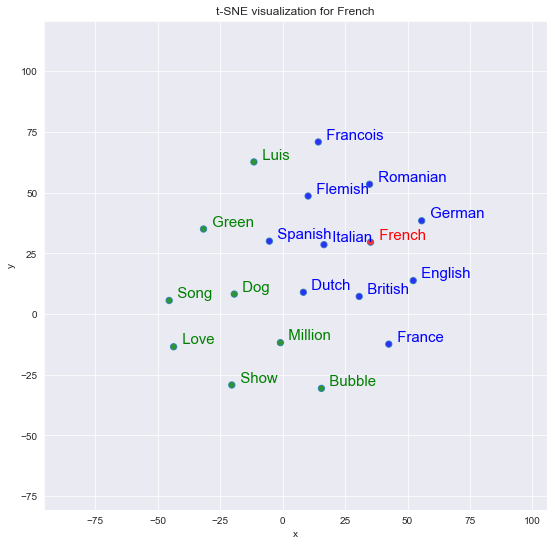

In [114]:
tsnescatterplot(w2v_model, 'french', ['million', 'green', 'dog', 'show', 'song', 'bubble', 'love', 'luis'])


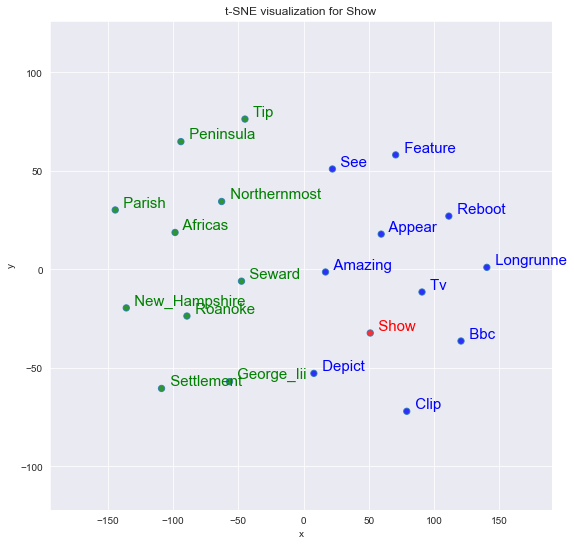

In [118]:
tsnescatterplot(w2v_model, 'show', [i[0] for i in w2v_model.wv.most_similar(negative=["show"])])